## Representation of performance with each parameter

# Libraries

In [13]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt

## Load data

#### Benchmark data

In [14]:
with open("./output_bench/benchmark.pkl", "rb") as f:
    list_benchmark = pkl.load(f)

### Data

In [15]:
with open("./evaluation/evaluation.pkl", "rb") as f:
    list_dataframes = pkl.load(f)

In [16]:
toplots = []
for subset in list_dataframes:
    toplot = subset.loc[
        :,
        [
            "test_settings",
            "eval_score_gemini-2.0-flash",
            "Relevance",
            "Correctness",
            "Groundedness",
            "Retrieval",
        ],
    ]
    values = [toplot.test_settings[0].split("_")[i] for i in [1, 3, 6, 7, 9]]
    toplot2 = {
        "Chunk_size": np.repeat(values[0], toplot.shape[0]),
        "LLM_model": np.repeat(values[1], toplot.shape[0]),
        "Embedding_Model": np.repeat(
            re.sub(r"recursive", "", values[2]), toplot.shape[0]
        ),
        "Recursive": np.repeat(values[3], toplot.shape[0]),
        "NumberofDocuments": np.repeat(values[4], toplot.shape[0]),
    }
    toplots.append(
        pd.concat(
            [
                pd.DataFrame(toplot2),
                toplot.loc[
                    :,
                    [
                        "eval_score_gemini-2.0-flash",
                        "Relevance",
                        "Correctness",
                        "Groundedness",
                        "Retrieval",
                    ],
                ],
            ],
            axis=1,
        )
    )
toplot_final = pd.concat(toplots)

## Generation of plots

We ensure that the correctness plot based on 1-5 scale contains numerical data and get values from 0 to 1.

In [17]:
toplot_final["eval_score_gemini-2.0-flash"] = toplot_final[
    "eval_score_gemini-2.0-flash"
].apply(lambda x: int(x) if isinstance(x, str) else 0)
toplot_final["eval_score_gemini-2.0-flash"] = (
    toplot_final["eval_score_gemini-2.0-flash"] / 5
)

We set the categories for plots

In [18]:
toplot_final["NumberofDocuments"] = pd.Categorical(
    values=toplot_final["NumberofDocuments"],
    categories=["4", "5", "6", "7", "8", "9", "10"],
    ordered=True,
)

## Check the variable with the highest std (more information)

In [19]:
sns.set_theme(font_scale=1, style="whitegrid")

Text(0.5, 0, 'Accuracy')

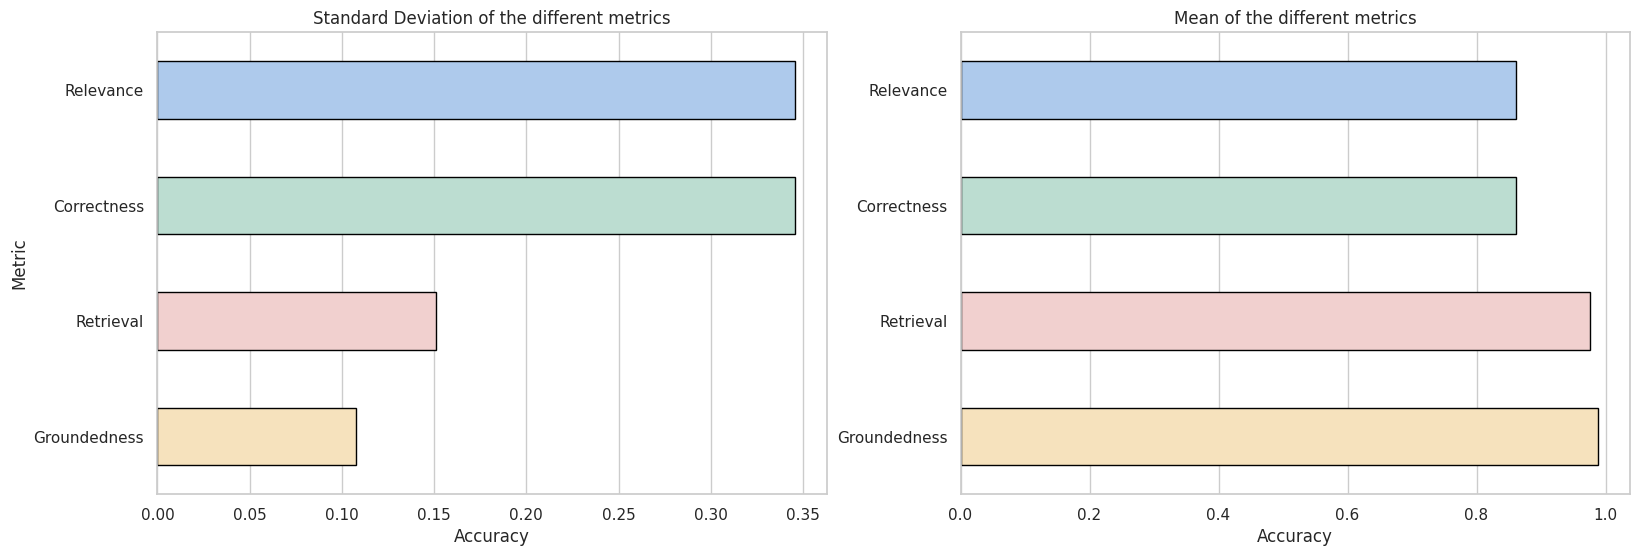

In [20]:
palette = {
    "Relevance": "#a3c9f7",
    "Correctness": "#b6e2d3",
    "Retrieval": "#f7cac9",
    "Groundedness": "#ffe5b4",
}

fig, ax = plt.subplots(1, 2, figsize=(19, 6))

plot_std = pd.DataFrame(
    {
        "Metric": ["Relevance", "Correctness", "Retrieval", "Groundedness"],
        "Std": [
            float(toplot_final["Relevance"].std()),
            float(toplot_final["Correctness"].std()),
            float(toplot_final["Retrieval"].std()),
            float(toplot_final["Groundedness"].std()),
        ],
        "Mean": [
            float(toplot_final["Relevance"].mean()),
            float(toplot_final["Correctness"].mean()),
            float(toplot_final["Retrieval"].mean()),
            float(toplot_final["Groundedness"].mean()),
        ],
    }
)


sns.barplot(
    data=plot_std,
    y="Metric",
    x="Std",
    palette=palette,
    hue="Metric",
    edgecolor="Black",
    ax=ax[0],
    width=0.5,
).set(title="Standard Deviation of the different metrics")
sns.barplot(
    data=plot_std,
    y="Metric",
    x="Mean",
    palette=palette,
    hue="Metric",
    edgecolor="Black",
    ax=ax[1],
    width=0.5,
).set(title="Mean of the different metrics")

ax[1].set_ylabel("Metric", visible=False)
ax[0].set_xlabel("Accuracy")
ax[1].set_xlabel("Accuracy")


In [21]:
plot_box = pd.DataFrame(
    {
        "Metric": ["Relevance", "Correctness", "Retrieval", "Groundedness"],
        "Std": [
            float(toplot_final["Relevance"].std()),
            float(toplot_final["Correctness"].std()),
            float(toplot_final["Retrieval"].std()),
            float(toplot_final["Groundedness"].std()),
        ],
        "Mean": [
            float(toplot_final["Relevance"].mean()),
            float(toplot_final["Correctness"].mean()),
            float(toplot_final["Retrieval"].mean()),
            float(toplot_final["Groundedness"].mean()),
        ],
    }
)

In [22]:
to_boxplot = toplot_final.groupby(
    ["Chunk_size", "Embedding_Model", "Recursive", "NumberofDocuments"], observed=False
)[["Relevance", "Groundedness", "Correctness", "Retrieval"]].mean()
to_boxplot = to_boxplot.melt()

Text(0, 0.5, 'Accuracy')

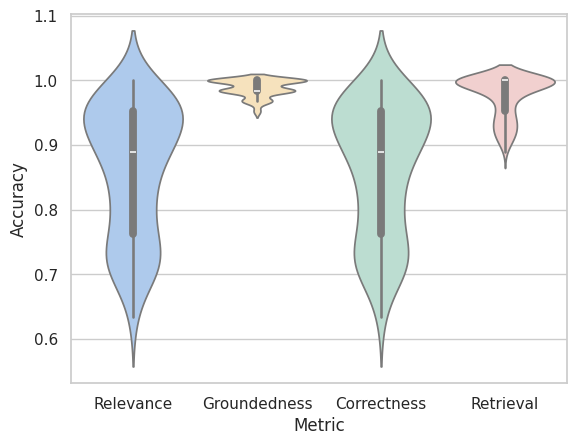

In [23]:
figure_violin = sns.violinplot(
    data=to_boxplot, y="value", x="variable", palette=palette, hue="variable"
)
plt.xlabel("Metric")
plt.ylabel("Accuracy")

In [158]:
figure_violin2 = figure_violin.get_figure()
figure_violin2.savefig("test.jpeg",dpi=600)

## Plot taking account all possible variables

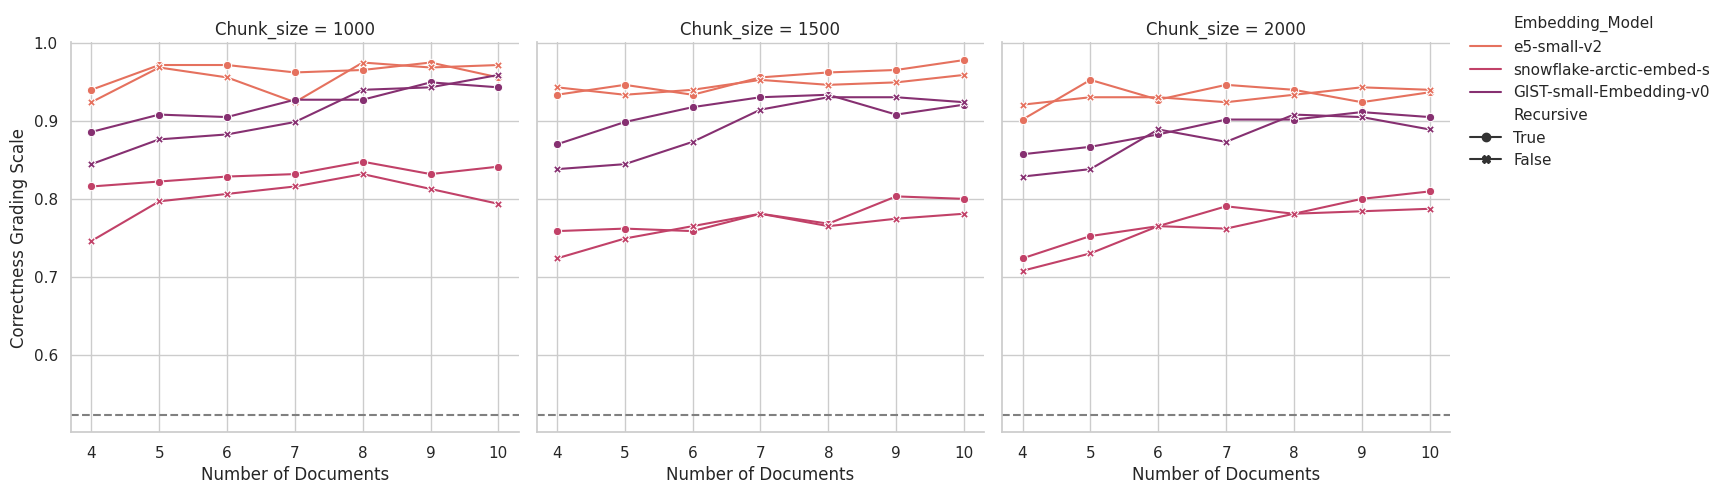

In [24]:
ax = sns.relplot(
    data=toplot_final,
    x="NumberofDocuments",
    y="eval_score_gemini-2.0-flash",
    hue="Embedding_Model",
    errorbar=None,
    style="Recursive",
    markers=True,
    dashes=False,
    palette="flare",
    col="Chunk_size",
    kind="line",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set_axis_labels("Number of Documents", "Correctness Grading Scale")

# Add a horizontal line to each subplot
for ax_i in ax.axes.flat:
    ax_i.axhline(
        y=list_benchmark[0]["Correctness"].mean(), color="gray", linestyle="--"
    )

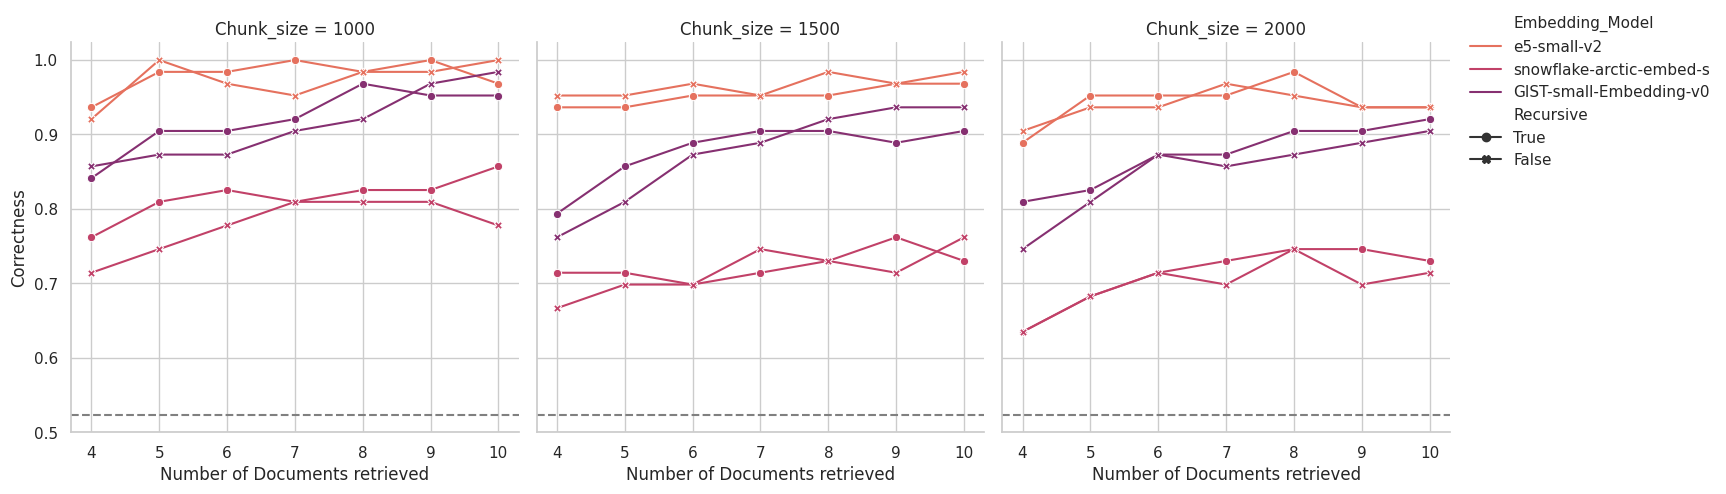

In [25]:
ax = sns.relplot(
    data=toplot_final,
    x="NumberofDocuments",
    y="Correctness",
    hue="Embedding_Model",
    errorbar=None,
    style="Recursive",
    markers=True,
    dashes=False,
    palette="flare",
    col="Chunk_size",
    kind="line"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel="Number of Documents retrieved", ylabel="Correctness")

# Add a horizontal line to each subplot
for ax_i in ax.axes.flat:
    ax_i.axhline(
        y=list_benchmark[0]["Correctness"].mean(), color="gray", linestyle="--"
    )

In [30]:
ax.savefig('correcteness.svg')

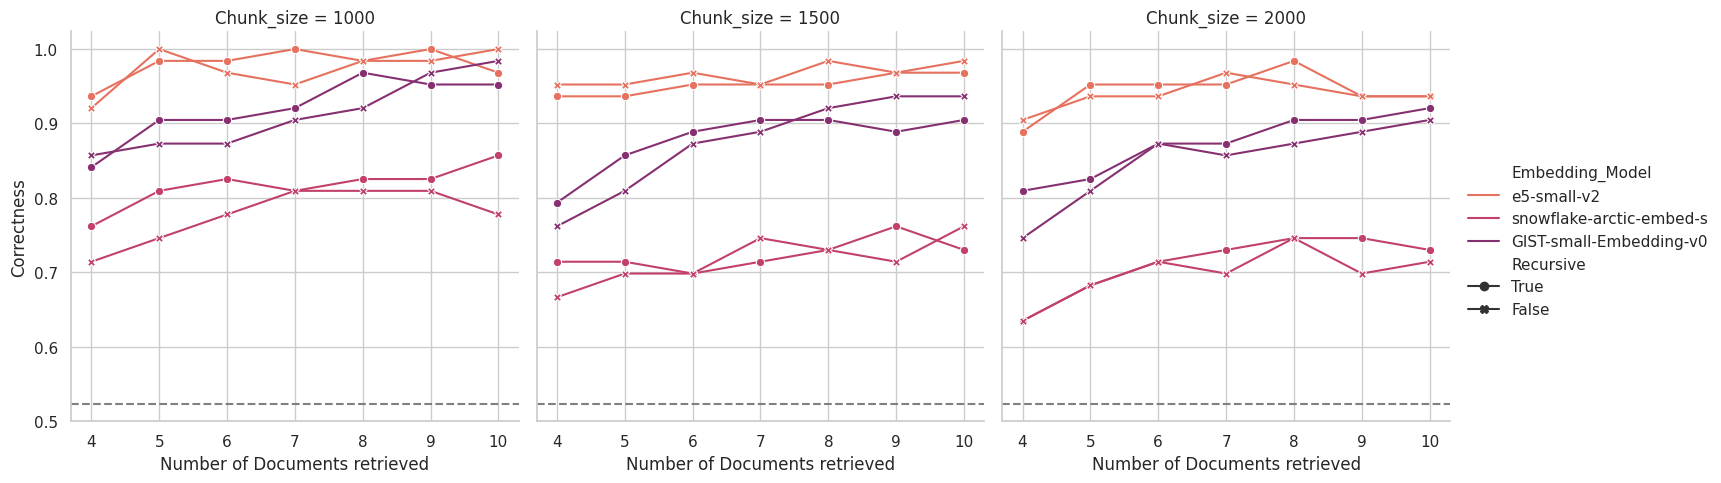

In [13]:
# To report

ax = sns.relplot(
    data=toplot_final,
    x="NumberofDocuments",
    y="Correctness",
    hue="Embedding_Model",
    errorbar=None,
    style="Recursive",
    markers=True,
    dashes=False,
    palette="flare",
    col="Chunk_size",
    kind="line"
)
ax.set(xlabel="Number of Documents retrieved", ylabel="Correctness")

# Add a horizontal line to each subplot
for ax_i in ax.axes.flat:
    ax_i.axhline(
        y=list_benchmark[0]["Correctness"].mean(), color="gray", linestyle="--"
    )

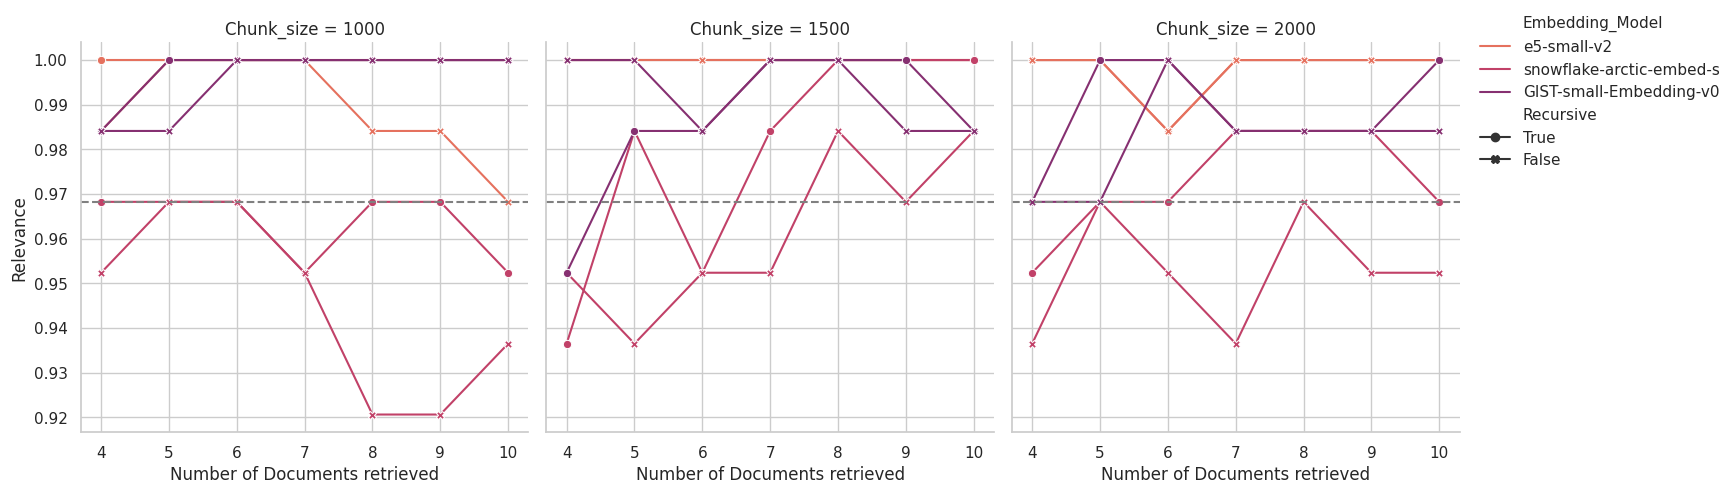

In [41]:
ax = sns.relplot(
    data=toplot_final,
    x="NumberofDocuments",
    y="Relevance",
    hue="Embedding_Model",
    errorbar=None,
    style="Recursive",
    markers=True,
    dashes=False,
    palette="flare",
    col="Chunk_size",
    kind="line",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel="Number of Documents retrieved", ylabel="Relevance")

# Add a horizontal line to each subplot
for ax_i in ax.axes.flat:
    ax_i.axhline(y=list_benchmark[0]["Relevance"].mean(), color="gray", linestyle="--")

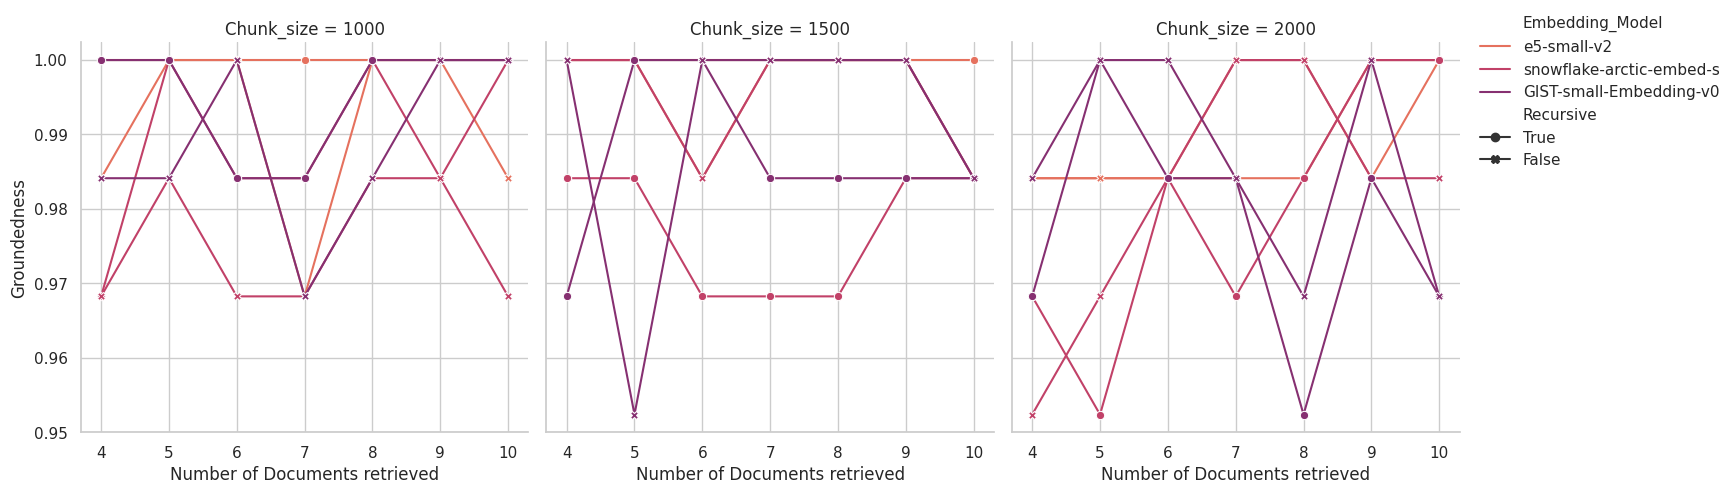

In [42]:
ax = sns.relplot(
    data=toplot_final,
    x="NumberofDocuments",
    y="Groundedness",
    hue="Embedding_Model",
    errorbar=None,
    style="Recursive",
    markers=True,
    dashes=False,
    palette="flare",
    col="Chunk_size",
    kind="line",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel="Number of Documents retrieved", ylabel="Groundedness")

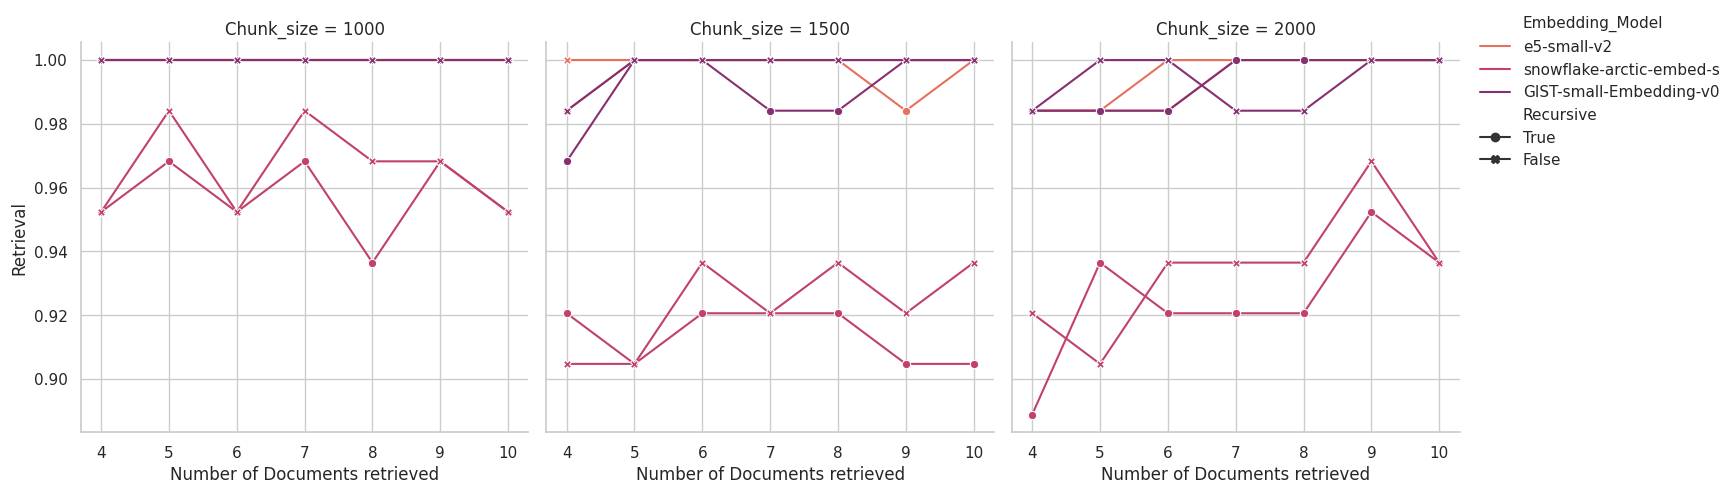

In [43]:
ax = sns.relplot(
    data=toplot_final,
    x="NumberofDocuments",
    y="Retrieval",
    hue="Embedding_Model",
    errorbar=None,
    style="Recursive",
    markers=True,
    dashes=False,
    palette="flare",
    col="Chunk_size",
    kind="line",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.85, 1))
ax.set(xlabel="Number of Documents retrieved", ylabel="Retrieval")

## Selecting the best parameters

In [153]:
best_parameters = toplot_final.groupby(['Embedding_Model','Recursive','NumberofDocuments','Chunk_size'])[['Correctness','Relevance','Groundedness','Retrieval']].mean().sort_values(ascending=False, by = ['Correctness','Relevance'])

/tmp/ipykernel_3780717/2403789903.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_parameters = toplot_final.groupby(['Embedding_Model','Recursive','NumberofDocuments','Chunk_size'])[['Correctness','Relevance','Groundedness','Retrieval']].mean().sort_values(ascending=False, by = ['Correctness','Relevance'])


In [152]:
np.round(best_parameters,4).to_csv("best_parameters.csv")